# Demystifying: Machine Learning

https://www.optica.org/events/congress/advanced_photonics_congress/program/demystifying/

Carlos Natalino $^1$ and Ben Mills $^2$

$^1$ Department of Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden. https://www.chalmers.se/en/persons/carda/

$^2$ University of Southampton, Southampton, UK. https://www.southampton.ac.uk/people/5x7lvp/doctor-ben-mills

## Part 2: Applications of Machine Learning

General links can be found here: https://github.com/carlosnatalino/demystifying-ml/

In [1]:
# run this code to delete all the training and testing data

import os
import random
import shutil

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import optim
import cv2
import matplotlib.pyplot as plt

if os.path.exists('./OPTICA/'):
    # delete existing dataset
    shutil.rmtree('./OPTICA/')

In [2]:
# Setting seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    # "cuda"
    # if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    # else "cpu"
    "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
# run this code to create the training and testing data
# have a look at the data folders (content/OPTICA/low_noise_data/...)

# Define constants
IMAGE_SIZE = 64
MIN_SLIT_SEPARATION = 1
MAX_SLIT_SEPARATION = 100
NUM_TRAINING_DATA = 10

# Directory paths
folder_low_noise_data = './OPTICA/low_noise_data/'
folder_high_noise_data = './OPTICA/high_noise_data/'
folder_figures = './OPTICA/figures/'

# Function to create directories if they don't exist
def create_directories(paths):
    for path in paths:
        os.makedirs(path, exist_ok=True)

# Create main directories
create_directories([folder_low_noise_data, folder_high_noise_data, folder_figures])

# Create folder structure for train/test pattern and sample data
def create_folder_structure(base_folders, min_sep, max_sep):
    for base_folder in base_folders:
        for data_type in ['pattern', 'sample']:
            for subset in ['train', 'test']:
                folder_path = os.path.join(base_folder, data_type, subset)
                os.makedirs(folder_path, exist_ok=True)
                for i in range(min_sep - 1, max_sep + 1):
                    os.makedirs(os.path.join(folder_path, f'{i:03}'), exist_ok=True)

create_folder_structure([folder_low_noise_data, folder_high_noise_data], MIN_SLIT_SEPARATION, MAX_SLIT_SEPARATION)

# Function to make slits
def make_slits(slit_separation):
    s = 512
    mid_s = s // 2
    d = slit_separation
    x = 10
    a = np.zeros((s, s))
    slit_h = np.random.randint(25, 75)

    a[mid_s-slit_h:mid_s+slit_h, mid_s-d//2-x:mid_s-d//2+x] = 1
    a[mid_s-slit_h:mid_s+slit_h, mid_s+d//2-x:mid_s+d//2+x] = 1
    return a

# Function to make pattern
def make_pattern(slits, noise):
    b = np.fft.fftshift(np.fft.fft2(slits))
    b = np.square(np.abs(b))
    crop = 25
    b_crop = b[256-crop:256+crop, 256-crop:256+crop]
    b_crop = cv2.resize(b_crop, (IMAGE_SIZE, IMAGE_SIZE))
    b_crop = b_crop / b_crop.max() * 100 + np.random.randint(0, noise + 1, (IMAGE_SIZE, IMAGE_SIZE))
    return b_crop

# Function to save image
def save_image(a, path):
    a = (a / a.max() * 255).astype('uint8')
    cv2.imwrite(path, a)

# Main data generation loop
def generate_data(num_training_data, min_sep, max_sep):
    for k in range(2):
        noise = 20 if k == 0 else 200
        data_folder = folder_low_noise_data if k == 0 else folder_high_noise_data
        print(f'creating {"low" if k == 0 else "high"} noise data')
        for j in range(num_training_data + 1):
            print(f'{j}/{num_training_data} steps')
            for i in range(min_sep - 1, max_sep + 1):
                slit_sep_str = f'{i:03}'
                rand_str = f'rand{np.random.randint(1e6):06}'
                s = f'{slit_sep_str}/separation{slit_sep_str}__{rand_str}.png'

                paths = {
                    'train_pattern': os.path.join(data_folder, 'pattern/train', s),
                    'test_pattern': os.path.join(data_folder, 'pattern/test', s),
                    'train_sample': os.path.join(data_folder, 'sample/train', s),
                    'test_sample': os.path.join(data_folder, 'sample/test', s)
                }

                slits = make_slits(i)
                slits_resized = cv2.resize(slits, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
                slits_rgb = np.dstack([(slits_resized / slits_resized.max() * 255).astype('uint8')] * 3)

                pattern = make_pattern(slits, noise)
                pattern_rgb = np.dstack([(pattern / pattern.max() * 255).astype('uint8')] * 3)

                if j == 0:
                    cv2.imwrite(paths['test_pattern'], pattern_rgb)
                    cv2.imwrite(paths['test_sample'], slits_rgb)
                else:
                    cv2.imwrite(paths['train_pattern'], pattern_rgb)
                    cv2.imwrite(paths['train_sample'], slits_rgb)

generate_data(NUM_TRAINING_DATA, MIN_SLIT_SEPARATION, MAX_SLIT_SEPARATION)

creating low noise data
0/10 steps
1/10 steps
2/10 steps
3/10 steps
4/10 steps
5/10 steps
6/10 steps
7/10 steps
8/10 steps
9/10 steps
10/10 steps
creating high noise data
0/10 steps
1/10 steps
2/10 steps
3/10 steps
4/10 steps
5/10 steps
6/10 steps
7/10 steps
8/10 steps
9/10 steps
10/10 steps


Training on high noise data


/Users/carda/projects/demystifying-ml/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Train Loss: 1236.0792, Test Loss: 855.0182
Epoch [2/10], Train Loss: 833.3723, Test Loss: 869.7707
Epoch [3/10], Train Loss: 862.7457, Test Loss: 588.4906
Epoch [4/10], Train Loss: 342.8978, Test Loss: 171.5209
Epoch [5/10], Train Loss: 114.5799, Test Loss: 97.1230
Epoch [6/10], Train Loss: 86.0546, Test Loss: 78.7832
Epoch [7/10], Train Loss: 81.2116, Test Loss: 106.6701
Epoch [8/10], Train Loss: 75.0868, Test Loss: 85.9264
Epoch [9/10], Train Loss: 63.1972, Test Loss: 60.4273
Epoch [10/10], Train Loss: 55.1573, Test Loss: 79.4218


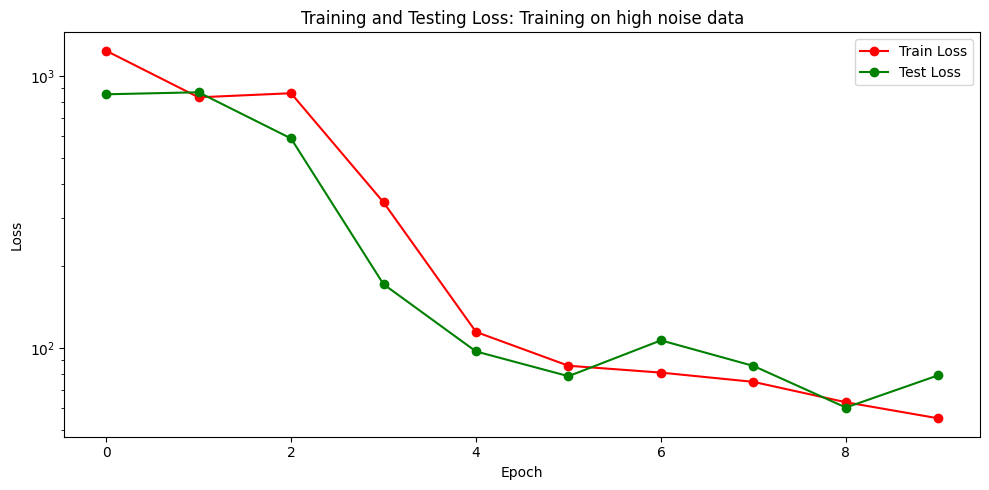

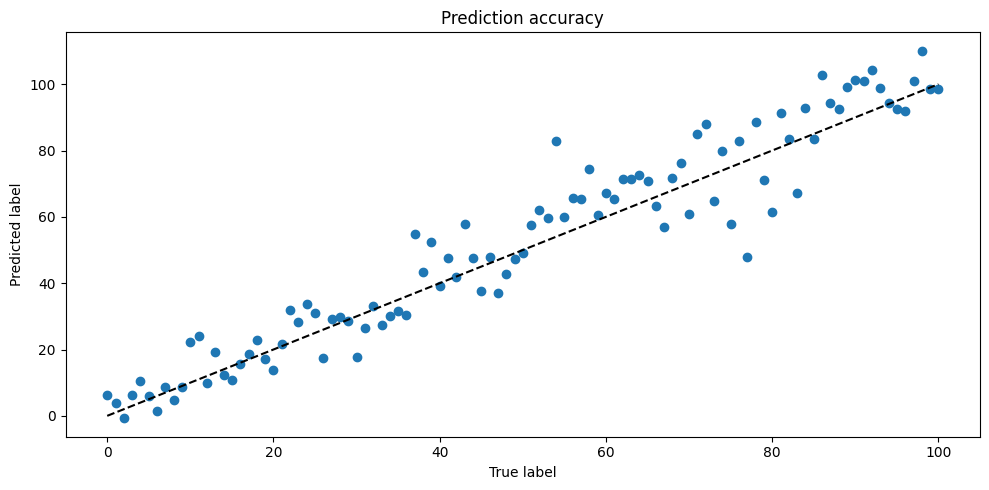

In [5]:
# run this code to train and test your convolutional neural network
# note: you can change the noise level (NOISE_LEVEL) between "low" and "high"

# Constants
NUMBER_OF_EPOCHS = 10
IMAGE_SIZE = 64
BATCH_SIZE = 10
LEARNING_RATE = 0.003
NOISE_LEVEL = 'high' # choose 'low' or 'high'

# Paths
folder_train = f'./OPTICA/{NOISE_LEVEL}_noise_data/pattern/train/'
folder_test = f'./OPTICA/{NOISE_LEVEL}_noise_data/pattern/test/'

# Print noise level being trained on
print(f'Training on {NOISE_LEVEL} noise data')

# Data transforms
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Example normalization, adjust as needed
])

# Data loaders
train_data = datasets.ImageFolder(root=folder_train, transform=transform_image)
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_data = datasets.ImageFolder(root=folder_test, transform=transform_image)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=1)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(64 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8), 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

# Initialize model, loss function, and optimizer
cnn = CNN().to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# Train the model
train_losses = []
test_losses = []

for epoch in range(NUMBER_OF_EPOCHS):
    cnn.train()
    epoch_train_loss = 0.0
    train_items = 0

    for images, labels in train_data_loader:
        b_x = images.to(device)
        b_y = labels.float().squeeze().to(device)
        pred = cnn(b_x).squeeze()
        loss = loss_func(pred, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * images.size(0)
        train_items += images.size(0)

    epoch_train_loss /= train_items
    train_losses.append(epoch_train_loss)

    # Test the model
    cnn.eval()
    epoch_test_loss = 0.0
    test_items = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_data_loader:
            b_x = images.to(device)
            b_y = labels.to(device)
            pred = cnn(b_x)
            all_preds.append(pred.item())
            all_labels.append(b_y.item())
            loss = loss_func(pred, b_y)
            epoch_test_loss += loss.item()
            test_items += 1

    epoch_test_loss /= test_items
    test_losses.append(epoch_test_loss)

    print(f'Epoch [{epoch + 1}/{NUMBER_OF_EPOCHS}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# Plot the losses
plt.figure(figsize=(10, 5))
plt.semilogy(train_losses, '-or', label='Train Loss')
plt.semilogy(test_losses, '-og', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Testing Loss: Training on {NOISE_LEVEL} noise data')
plt.legend()
plt.tight_layout()
# plt.savefig(f"{folder_figures}/{NOISE_LEVEL}_loss.png")
plt.show()

# Generate the comparison plot
plt.figure(figsize=(10, 5))
plt.scatter(all_labels, all_preds)
plt.plot([0,100],[0,100],'--k')
plt.title('Prediction accuracy')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.tight_layout()
# plt.savefig(f"{folder_figures}/{NOISE_LEVEL}_true_vs_pred.png")
plt.show()